In [2]:
! export JAX_PLATFORMS=cpu

/gpfs/cfel/group/cmi/common/psi4/psi4conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Rotational cluster states of H2S

In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import h5py
from rovib.symtop import symtop_on_grid

Read file with rovibrational energies of H2S, produced by `h2s_rovib.ipynb`, identify cluster states and plot the rotation energy level diagram.

In [101]:
pmax = 20
j_angmom = 50
h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
energies = []
symmetries = []
energy_ind = []
for sym in h5["energies"].keys():
    enr = h5["energies"][sym][:]
    coefs = h5["coefficients"][sym][:]
    qua = np.array(
        [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
    )
    energies.append(enr)
    symmetries.append([sym for _ in range(len(enr))])
    energy_ind.append([i for i in range(len(enr))])
energies = np.concatenate(energies, axis=0)
symmetries = np.concatenate(symmetries, axis=0)
energy_ind = np.concatenate(energy_ind, axis=0)
ind = np.argsort(energies)
energies = energies[ind]
symmetries = symmetries[ind]
energy_ind = energy_ind[ind]

tol = 1e-3
cluster_state_ind = []
for i in range(len(energies) - 4):
    enr_list = energies[i : i + 4]
    sym_list = symmetries[i : i + 4]
    if np.all(np.abs(enr_list - enr_list[0]) < tol):
        cluster_state_ind.append(i)
        print(energy_ind[i], enr_list, sym_list)

277 [24708.81879579 24708.81879579 24708.81890005 24708.81890006] ['B2' 'A2' 'B1' 'A1']
516 [26642.48230324 26642.48232554 26642.48259022 26642.4826586 ] ['B2' 'A2' 'A1' 'B1']
636 [27304.58779895 27304.58779898 27304.58780728 27304.58780739] ['A1' 'B1' 'B2' 'A2']
779 [28038.87972909 28038.87972996 28038.88005428 28038.88005631] ['A1' 'B1' 'A2' 'B2']
808 [28469.77709315 28469.77709748 28469.7771687  28469.77717243] ['A2' 'B2' 'B1' 'A1']
934 [28730.61559772 28730.61559774 28730.61561417 28730.61561428] ['B2' 'A2' 'A1' 'B1']
1066 [29237.48114925 29237.4811494  29237.48132593 29237.4813298 ] ['B2' 'A2' 'A1' 'B1']
1049 [29477.27273421 29477.27275097 29477.27275111 29477.27278373] ['B1' 'A2' 'B2' 'A1']
1138 [29807.06249182 29807.06249198 29807.06253328 29807.06253352] ['B1' 'A1' 'A2' 'B2']
1320 [30424.00057976 30424.00111841 30424.00115316 30424.00121593] ['A2' 'A1' 'B1' 'B2']
1376 [30618.56661024 30618.5666226  30618.56665838 30618.5666954 ] ['B1' 'A2' 'B2' 'A1']
1631 [31064.61754347 31064.

Visualise the rotational densitities of cluster states

In [140]:
npoints = 200
# alpha = np.linspace(0, 2 * np.pi, npoints)
alpha = [0]
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
# gamma = [0]
grid3d = np.array([elem for elem in itertools.product(alpha, beta, gamma)])
mgrid = np.meshgrid(beta, gamma)

In [47]:
j = 10
psi, k_list, jktau_list = symtop_on_grid(j, grid3d)
dens = np.abs(psi)**2

In [48]:
dens.shape

(21, 21, 10000)

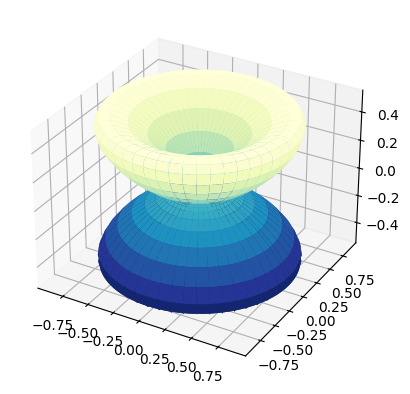

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

m, k = 5, 10
d = dens[j + m, j + k, :].reshape(npoints, -1).T
r = d / np.max(d)
r = r.reshape(npoints, -1)

phi, theta = mgrid
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)

In [141]:
def psi_on_grid(
    pmax: int,
    j_angmom: int,
    m_angmom: int,
    sym: str,
    state_ind: int,
    euler_grid,
):
    # precompute symmetric-top functions in Wang's representation
    psi_rot, _, jktau_list = symtop_on_grid(j_angmom, euler_grid)
    m_ind = [m for m in range(-j_angmom, j_angmom + 1)].index(m_angmom)
    psi_rot = psi_rot[m_ind, :, :]

    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    enr = h5["energies"][sym][state_ind]
    coefs = h5["coefficients"][sym][:, 0, state_ind]
    qua = np.array(
        [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
    )
    vib_qua = qua[:, 2:6]
    rot_qua = qua[:, 6:9]

    # compute rotational part for all basis functions
    ktau_ind = [
        np.where(
            (jktau_list[:, 0] == str(j_angmom))
            & (jktau_list[:, 1] == k)
            & (jktau_list[:, 2] == tau)
        )[0][0]
        for (k, tau) in rot_qua[:, :2]
    ]
    psi = psi_rot[ktau_ind,:]

    # unique set of vibrational quanta
    vib_qua_unique = np.unique(vib_qua, axis=0)
    v_ind = [
        np.where(
            (vib_qua[:, 0] == v1)
            & (vib_qua[:, 1] == v2)
            & (vib_qua[:, 2] == v3)
            & (vib_qua[:, 3] == vsym)
        )[0]
        for (v1, v2, v3, vsym) in vib_qua_unique
    ]
    unique_vec = np.zeros((len(qua), len(vib_qua_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1

    psi_rovib = np.einsum("i,ig,iu->ug", coefs, psi, unique_vec, optimize="optimal")
    return psi_rovib, enr

In [154]:
# psi, enr = psi_on_grid(20, 50, 50, "B2", 277, grid3d)
psi, enr = psi_on_grid(20, 50, 50, "B2", 516, grid3d)
print(enr)

26642.482303239183


In [155]:
dens = np.real(np.sum(np.conj(psi) * psi, axis=0)) * np.sin(grid3d[:,1])

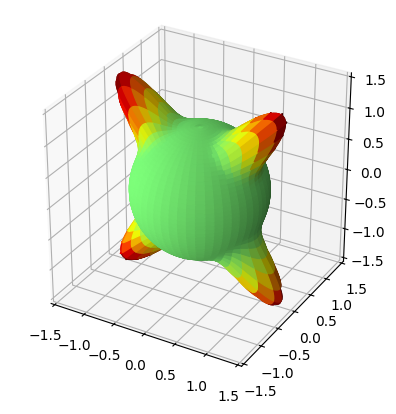

In [156]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect(aspect=(1, 1, 1))
ax.axes.set_xlim3d(left=-1.5, right=1.5) 
ax.axes.set_ylim3d(bottom=-1.5, top=1.5) 
ax.axes.set_zlim3d(bottom=-1.5, top=1.5) 

d = dens.reshape(npoints, -1).T
r = d / np.max(d) + 1
r = r.reshape(npoints, -1)

theta, phi = mgrid
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)
ax.plot_surface(x, y, z, facecolors = cm.jet(r/np.amax(r)))